# Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm

In [1]:
library(tidyverse)

# Installed just by typing install.packages('bnlearn')

#install.packages('bnlearn')
library(bnlearn)

# This was a bit more complicated to install:
# install.packages("BiocManager")
# BiocManager::install("Rgraphviz")

#install.packages('BiocManager')
#BiocManager::install('Rgraphviz')
library(Rgraphviz)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:bnlearn’:

    path, score


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

   

## 1. Implement the algorithm K2 in R and check its performances with the test data set given in [2]

The problem of finding the best belief-network structure $B_S$ is a maximization problem of the quantity:

$$P(B_S|D)\propto P(B_S,D)$$

$$\max{\left[P(B_S|D)\right]}\leftrightarrow \max{\left[P(B_S,D)\right]}$$

Robinson formula computes the number of possible Networks given the number of nodes. It is relevant to show how quickly the problem tackled scales when the number of nodes _n_ increases.

As shown in the next cell, the complexity of this task is exponential.

In [2]:
# Robinson recursive formula to compute the number of possible belief-network stuctures
# that contains n nodes
# From: A Bayesian Method for the Induction of Probabilistic Networks from Data, p. 319
n.networks.structure <- function(n)
    {
        if(n <= 1){return(1)}
        else
            {
                i <- 1
                res <- 0
                while(i <= n)
                    {
                        res <- res + ((i%%2)*2 - 1)*(choose(n,i)*(2^(i*(n-i)))*n.networks.structure(n-i))
                        i <- i + 1
                    }

                return(res)
            }
    }

for(i in 1:8)
    {
        cat('For n=',i,'the number of possible structures is: ',n.networks.structure(i),'\n')
    }


For n= 1 the number of possible structures is:  1 
For n= 2 the number of possible structures is:  3 
For n= 3 the number of possible structures is:  25 
For n= 4 the number of possible structures is:  543 
For n= 5 the number of possible structures is:  29281 
For n= 6 the number of possible structures is:  3781503 
For n= 7 the number of possible structures is:  1138779265 
For n= 8 the number of possible structures is:  783702329343 


 
 

\
$$P(B_S,D)=P(B_S)\prod_{i=1}^n\prod_{j=1}^{q_i}\frac{(r_i-1)!}{(N_{ij}+r_i - 1)!}\prod_{k=1}^{r_i}N_{ijk}! \tag{1}$$

* $P(B_S)$ is the prior probability of the model, if we assume every model to be as likely as the others then it is just a constant
* $r_i$ is the number of possible value assignments of the i-th variable
* $\pi_i$ is the set of parents for the node i
* $q_i$ the number of unique instantiations of $\pi_i$ relative to D
* $w_{ij}$ denotes the jth unique instantiation of $\pi_i$ relative to D
* $N_{ijk}$ is the number of cases in D in which the variable $x_i$ has the value $v_{ik}$ and $\pi_i$ is instantiated as $w_{ij}$
* $N_{ij}=\sum_{k=1}^{r_i}N_{ijk}$

**My attempt of explaining better the formula:**
Consider the following Bayesian Network:

<img src="https://i.ibb.co/n3hgVxm/RCOv-Zs-QPAZmc-Sym-L.png" width="300"/>

An example of this Network can be:
* **X1**: it has rained
* **X2**: the automatic dripper was recently on
* **X3**: I slip and fall
* **X4**: I arrive late to work

The event _slip and fall_ depends on wether the floor is wet. And _falling_ may have some causality on _arriving late to work_.\
Let D be the Data about these events,  consider this set:

| X1 | X2 | X3 | X4 |
|----|----|----|----|
| 0  | 0  | 0  | 0  |
| 0  | 0  | 0  | 1  |
| 0  | 1  | 0  | 0  |
| 1  | 1  | 1  | 1  |
| 0  | 1  | 1  | 1  |
| 1  | 0  | 1  | 1  |


The probability of the Bayesian Network to be true given the data is proportional to $P(B_S,D)$ given by the formula (1).

For simplicity, consider the events of each node being only 0 or 1:
$$X1,X2,X3,X4\, \in\,\{0,1\} \qquad\left(=\,\{TRUE,FALSE\}\right)$$

The first term of the $\Pi$ goes through each nodes, let us explicit them one by one:
* $n=1$
    * $r_1=2;\qquad$  X1 can be either 0 or 1
    * $\pi_1 = \emptyset;\qquad$ since X1 has no parents
    * $q_1 = 1;\qquad$ Since $\pi_1=\emptyset$, the possible rearrangments are just one
    * $N_{1jk};\qquad$ If the node has no parents, this ends up being the counts of unique terms
    * $N_{1j};\qquad$ always ends up being the sum of the terms inside the last $\Pi$
    
    $$\frac{(2-1)!}{(N_{11}+2 - 1)!}\prod_{k=1}^{2}N_{11k}! = \frac{\prod_{k=1}^{2}N_{11k}!}{(N_{11} +1)!}=$$
    (For k=1 we count the zeros, for k=2 we count the ones)
    $$=\frac{4!2!}{(4+2 +1)!}=0.0095$$

* $n=2$
    Exactly the same, only the terms $N_{ij}$ and $N_{ijk}$ change
    $$\frac{(2-1)!}{(N_{21}+2 - 1)!}\prod_{k=1}^{2}N_{21k}! = \frac{\prod_{k=1}^{2}N_{21k}!}{(N_{21} +1)!}=\frac{3!3!}{(3+3+1)!}=0.0071$$

* $n=3$\
    X3 has parents X1 and X2, this means:
    * $r_3=2;\qquad$  X3 can be either 0 or 1
    * $\pi_3 = \{X1,X2\};$
    * $q_3 = 4;\qquad$ Since both X1 and X2 can assume two values, the number of all possible permutation of the unique elements of X1 and X2 are 4
    * $w_{3j}=\{ \{0,0\},\{0,1\},\{1,0\},\{1,1\}\}$
    * $N_{3jk};\qquad$ Is the counts of times in D that X3 assumes the k-th value, and $\{X1,X2\}$ assume the j-th value from $w_{3j}$
    
    $$\prod_{j=1}^{4}\frac{(2-1)!}{(N_{3j}+ 2- 1)!}\prod_{k=1}^{2}N_{3jk}! = \prod_{j=1}^{4}\frac{\prod_{k=1}^{2}N_{3jk}!}{(N_{3j}+ 1)!}$$
     * j = 1\
     We consider when X1 and X2 assume the value $w_{31}=\{0,0\}$
     When \{X1,X2\}=\{0,0\}, X3 is 0 twice (k=1) and is never 1 (k=2)
     
     * j = 2\
     We consider when X1 and X2 assume the value $w_{31}=\{0,1\}$
     When \{X1,X2\}=\{0,1\}, X3 is 0 once (k=1) and once (k=2)
     
     * and so on...
     
     $$\prod_{j=1}^{4}\frac{\prod_{k=1}^{2}N_{3jk}!}{(N_{3j}+ 1)!}=\frac{0!2!}{3!}\frac{1!1!}{3!}\frac{0!1!}{2!}\frac{0!1!}{2!}=0.028$$

* $n=4$\
    For X4 the computation is easier than for X3 because there's only one parent node, meaning that q is only 2:
    $$\prod_{j=1}^{2}\frac{(2-1)!}{(N_{4j}+ 2- 1)!}\prod_{k=1}^{2}N_{4jk}!=\prod_{j=1}^{2}\frac{ \prod_{k=1}^{2}N_{4jk}! }{(N_{4j}+ 2- 1)!}=$$
    
    To compute $N_{4jk}$ we must count the times X4 is 0/1 when X3 assumes the values 0 and 1:
    
    $$=\frac{2!1!}{4!}\frac{3!0!}{4!}=0.021$$

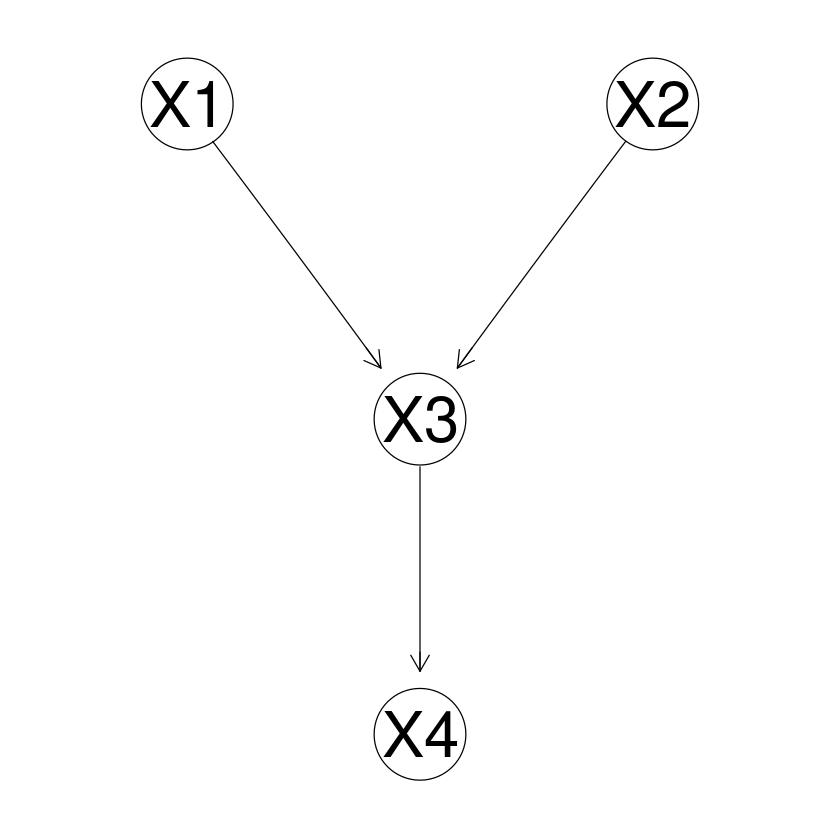

In [3]:
toy <- read.table("./dataset/toyexample.txt", header = TRUE, stringsAsFactors = TRUE)
toy.bn <- model2network("[X1][X2][X3|X1:X2][X4|X3]")
graphviz.plot(toy.bn)

In [4]:
############ AUXILIARY FUNCTIONS ###############

prob.noparents <- function(D,namecol,prod)
    {
        lprod <- log(prod)
        col <- dplyr::pull(D, namecol)
        nunique <- length(unique(col))
        lprod <- lprod+lfactorial(nunique-1)
        den <- nunique - 1
    
        for(i in 1:nunique)
            {
                lprod <- lprod + lfactorial(length(col[col == unique(col)[i]]))
                den <- den + length(col[col == unique(col)[i]])
            }
        lprod <- lprod-lfactorial(den)

        prod <- exp(lprod)
    
        return(prod)
    }

is.eq <- function(row1,row2){return(row1 == row2)}

prob.parents <- function(BN,D,namecol,prod)
    {
        lprod <- log(prod)
        col <- dplyr::pull(D, namecol)
        parents <- parents(BN, namecol)
        n.parents <- length(parents)
        col.parents <- D[parents]
        r <- length(unique(col))

        q <- 1
        combined <- list()
        for(j in 1:length(parents))
            {
                q <- q*length(unique(col.parents[,j]))
                combined[[j]] <- unique(col.parents[,j])    
            }
        combinations <- do.call(expand.grid, combined)
        # for j in 1:qi
        for(j in 1:q)
            {
                w  <- combinations[j,]
                # Compute Nijk!
                nij <- 0
                for(k in 1:r)
                    {
                        wij <- c(w,unique(col)[k])
                        nijk <- sum(apply(apply(cbind(col.parents, col),1,is.eq,row2=wij),2,all))
                        nij <- nij + nijk
                        lprod <- lprod + lfactorial(nijk)
                    }
                lprod <- lprod + lfactorial(r - 1) - lfactorial(nij + r - 1)
            }
        prod <- exp(lprod)
        return(prod)

    }

#############################################

In [5]:
prob.model <- function(BN,D)
    {
        nvar <- length(nodes(BN))
        prod <- 1
        for(i in 1:nvar)
            {
                if(length(parents(BN, nodes(BN)[i])) == 0)
                    {prod <- prob.noparents(D,nodes(BN)[i],prod)}
                else
                    {prod <- prob.parents(BN,D,nodes(BN)[i],prod)}
                
            }
    
        return(prod)
    }

Here we check if the function wrote gives back the same result present in the paper Cooper for the same Bayesian Networks and the same Data Samples

In [6]:
ex <- read.table("./dataset/cooper.txt", header = TRUE, stringsAsFactors = TRUE)

P(B1,D)=P(B1) 2.226854e-09 



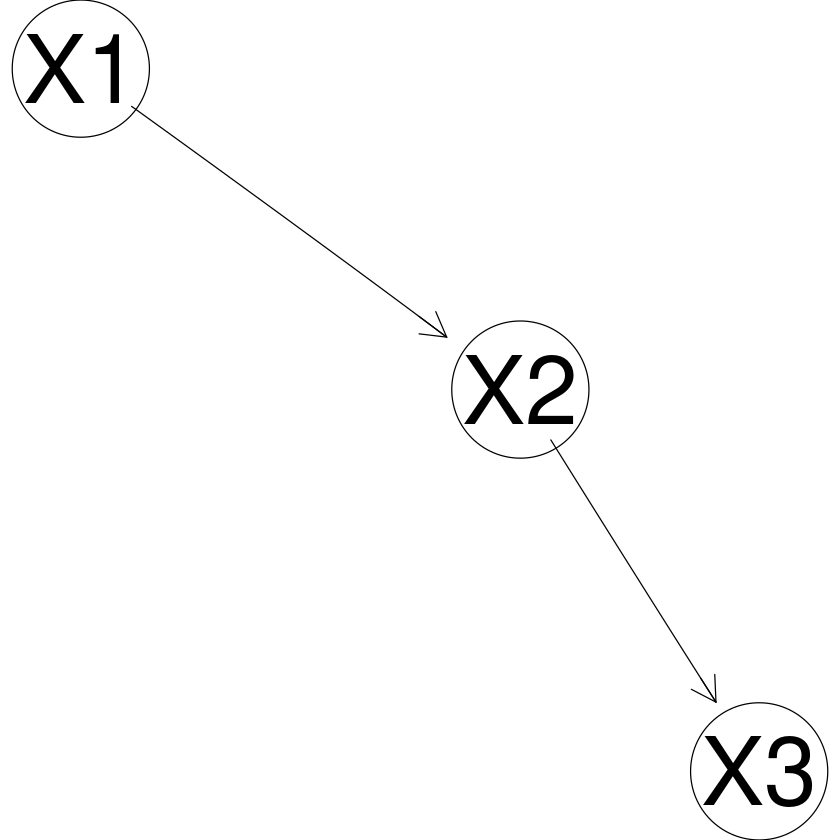

In [7]:
ex.bn1 <- model2network("[X1][X2|X1][X3|X2]")
graphviz.plot(ex.bn1,layout = 'neato')
cat('P(B1,D)=P(B1)',prob.model(ex.bn1,ex),'\n\n')

P(B2,D)=P(B2) 2.226854e-10 



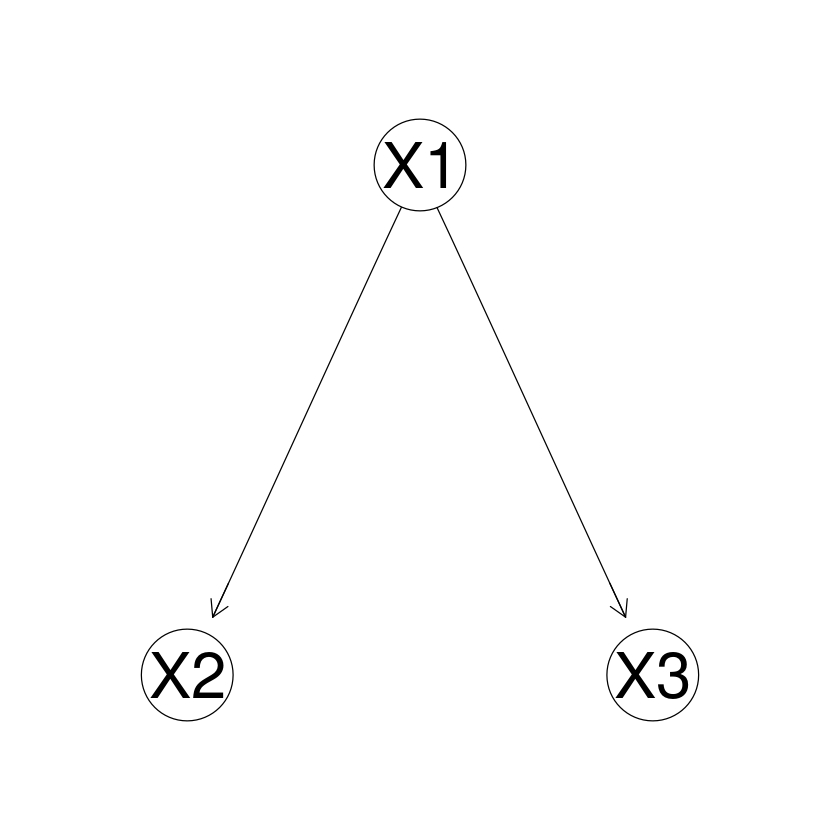

In [8]:
ex.bn2 <- model2network("[X1][X2|X1][X3|X1]")
graphviz.plot(ex.bn2)
cat('P(B2,D)=P(B2)',prob.model(ex.bn2,ex),'\n\n')

The general function seem to work well since it reproduces the same values of the paper aswell!

### Implementing K2 algorithm

In [9]:
f <- function(BN,D,i)
            {
                prod <- 1
            
                if(length(parents(BN, nodes(BN)[i])) == 0)
                    {prod <- prob.noparents(D,nodes(BN)[i],prod)}
                else
                    {prod <- prob.parents(BN,D,nodes(BN)[i],prod)}
               
                return(prod)
            }

In [10]:
K2 <- function(N,D,u)
    {
        BN <- empty.graph(nodes = N)
    
        for(i in 2:length(N))
            {
                p.old <- f(BN,D,i)
                ok.to.proceed <- TRUE
                j <- i - 1
                                
                while(ok.to.proceed & (length(parents(BN,nodes(BN)[i])) < u) )
                    {   
                        j <- i - 1
                        proposal <- c()
                    
                        while(j > 0)
                            {
                                    BN.proposal <- set.arc(BN, from=nodes(BN)[j], to=nodes(BN)[i])
                                    proposal <- c(proposal, f(BN.proposal,D,i))

                                    j <- j - 1 
                            }
                        
                        p.new <- max(proposal)
                        best.BN   <- set.arc(BN, from=nodes(BN)[i - match(max(proposal),proposal)], to=nodes(BN)[i])
                        if(p.new > p.old)
                            {
                                    p.old <- p.new
                                    BN <- best.BN
                            }
                        else{ok.to.proceed <- FALSE}
                    }
                
            }
        
        return(BN)
    }

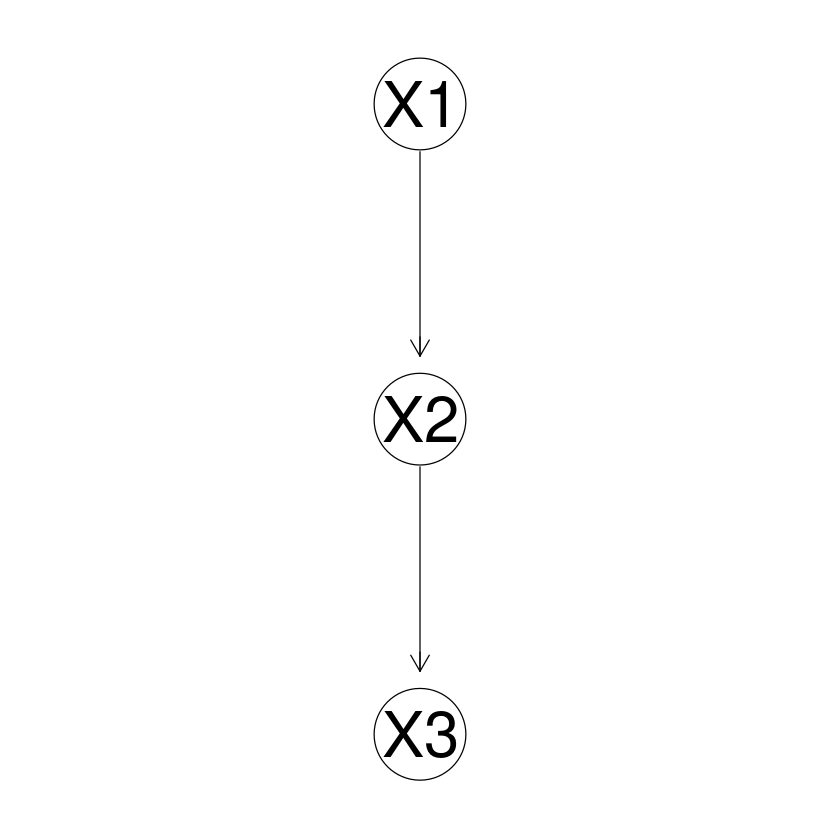

In [11]:
graphviz.plot(K2(c('X1','X2','X3'),ex,3))

### Testing on SURVEY database

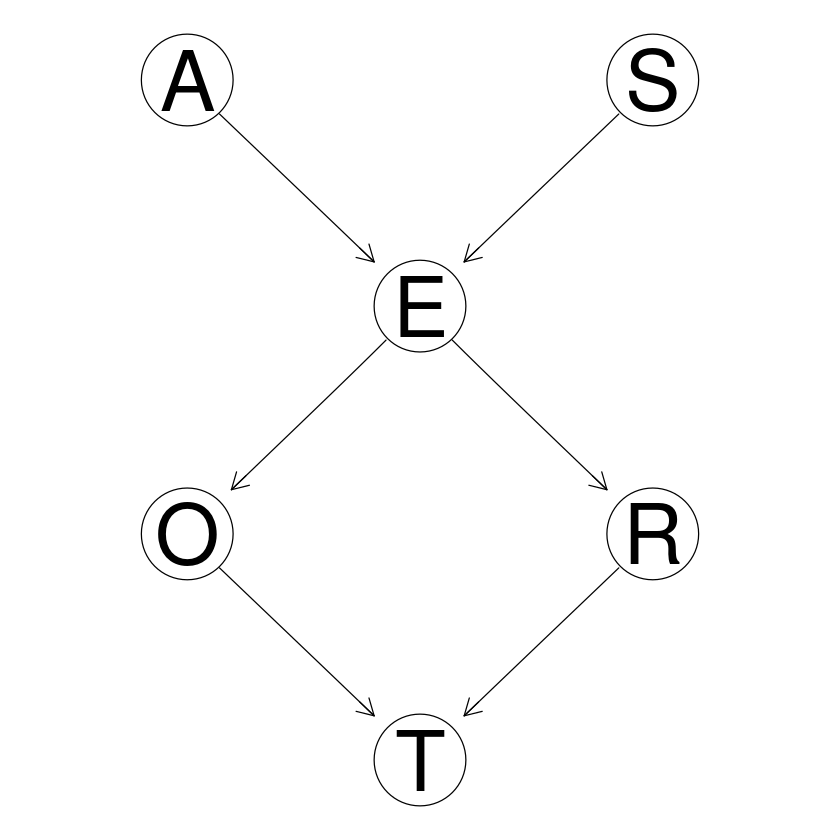

In [12]:
# Setting the nodes
tus_dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

# Setting the arc (the edges)
tus_dag <- set.arc(tus_dag, from = "A", to = "E")
tus_dag <- set.arc(tus_dag, from = "S", to = "E")
tus_dag <- set.arc(tus_dag, from = "E", to = "O")
tus_dag <- set.arc(tus_dag, from = "E", to = "R")
tus_dag <- set.arc(tus_dag, from = "O", to = "T")
tus_dag <- set.arc(tus_dag, from = "R", to = "T")

survey <- read.table("./dataset/survey.txt", header = TRUE, stringsAsFactors = TRUE)
graphviz.plot(tus_dag)

In [13]:
# This function should compute the best survey model and plot it but it does not work right now
# graphviz.plot(K2(c("A", "S", "E", "O", "R", "T"),survey,3))

## 2. Implement and test the K2 algorithm with the test data sets ([2]).  Investigate if it is possible to code it inside the bnstruct R package 